In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('car_prices.csv')

In [3]:
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [5]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

# Data Cleaning and Processing

In [6]:
df.dropna(subset= 'vin', inplace=True)

In [7]:
df.duplicated(subset = 'vin').sum()

8536

In [8]:
df = df.drop_duplicates(subset='vin', keep= 'first') 

In [9]:
# Calculate % missing
missing_summary = df.isnull().sum().reset_index()
missing_summary.columns = ['columns', 'null_count']
missing_summary['pct_missing'] = (missing_summary['null_count'] / len(df)) * 100

missing_summary.sort_values(by='pct_missing', ascending=False)

,columns,null_count,pct_missing
5,transmission,64472,11.715855
4,body,12987,2.359998
8,condition,11785,2.141571
3,trim,10451,1.899156
2,model,10202,1.853908
1,make,10104,1.836099
10,color,744,0.135200
11,interior,744,0.135200
9,odometer,88,0.015991
13,mmr,13,0.002362


In [10]:
# Checking for skewness in data
skew_values = df[['odometer', 'mmr', 'sellingprice', 'condition']].skew()
print(skew_values)

odometer        1.849216
mmr             2.001330
sellingprice    1.956870
condition      -0.831432
dtype: float64


### Median Imputation for Skewed Numeric Features

The numeric columns 'odometer', 'mmr', and 'sellingprice' exhibit high positive skewness (1.85+, 2.00+, 1.95+, respectively). To avoid distortion from extreme values, I chose **median imputation** over mean. This preserves central tendency while minimising bias introduced by outliers.

In [11]:
# Columns to exclude from imputation
exclude_cols = ["vin"]

# Select numeric columns
numeric_cols = df.select_dtypes(include="number").columns.difference(exclude_cols)

# Impute missing values in selected columns with their mean
for col in numeric_cols:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

### Outlier Detection Using IQR Method

To identify extreme values, I applied the Interquartile Range (IQR) method. This approach is robust to skewed distributions and does not assume normality.

In [12]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

col = ['odometer', 'mmr', 'sellingprice', 'condition']
for c in col:
    iqr = detect_outliers_iqr(df[c])
    outlier_count = iqr.count()
    print(f"Number of outliers in {c}: {outlier_count}")

Number of outliers in odometer: 10213
Number of outliers in mmr: 16052
Number of outliers in sellingprice: 16072
Number of outliers in condition: 0


### Outlier Summary Using IQR Method

After applying the Interquartile Range (IQR) method to detect outliers in key numeric columns, the following counts were observed:

| Column         | Outlier Count | Interpretation |
|----------------|----------------|----------------|
| 'odometer'     | 10,213         | High-mileage vehicles with long right tail |
| 'mmr'          | 16,052         | Market values skewed by luxury or rare models |
| 'sellingprice' | 16,072         | Price distribution dominated by lower-end vehicles |
| 'condition'    | 0              | No outliers detected; distribution likely bounded or ordinal |

These results reinforce earlier skewness diagnostics and justify the use of **median imputation** over mean.

In [13]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Set outliers to NaN
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan

In [14]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

# Columns to exclude from imputation
exclude_cols = ["vin", "condition"]
# Select numeric columns
numeric_cols = df.select_dtypes(include="number").columns.difference(exclude_cols)

# Apply Robust Scaler to handle outliers
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

knn_imputer = KNNImputer(n_neighbors=5)

# Use KNNImputer to impute missing values
imputed_data = knn_imputer.fit_transform(scaled_df)
imputed_df = pd.DataFrame(imputed_data, columns=scaled_df.columns)

# Inverse transform to get originally scaled data
original_scaled_df = scaler.inverse_transform(imputed_data)
df1 = pd.DataFrame(original_scaled_df, columns=scaled_df.columns)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


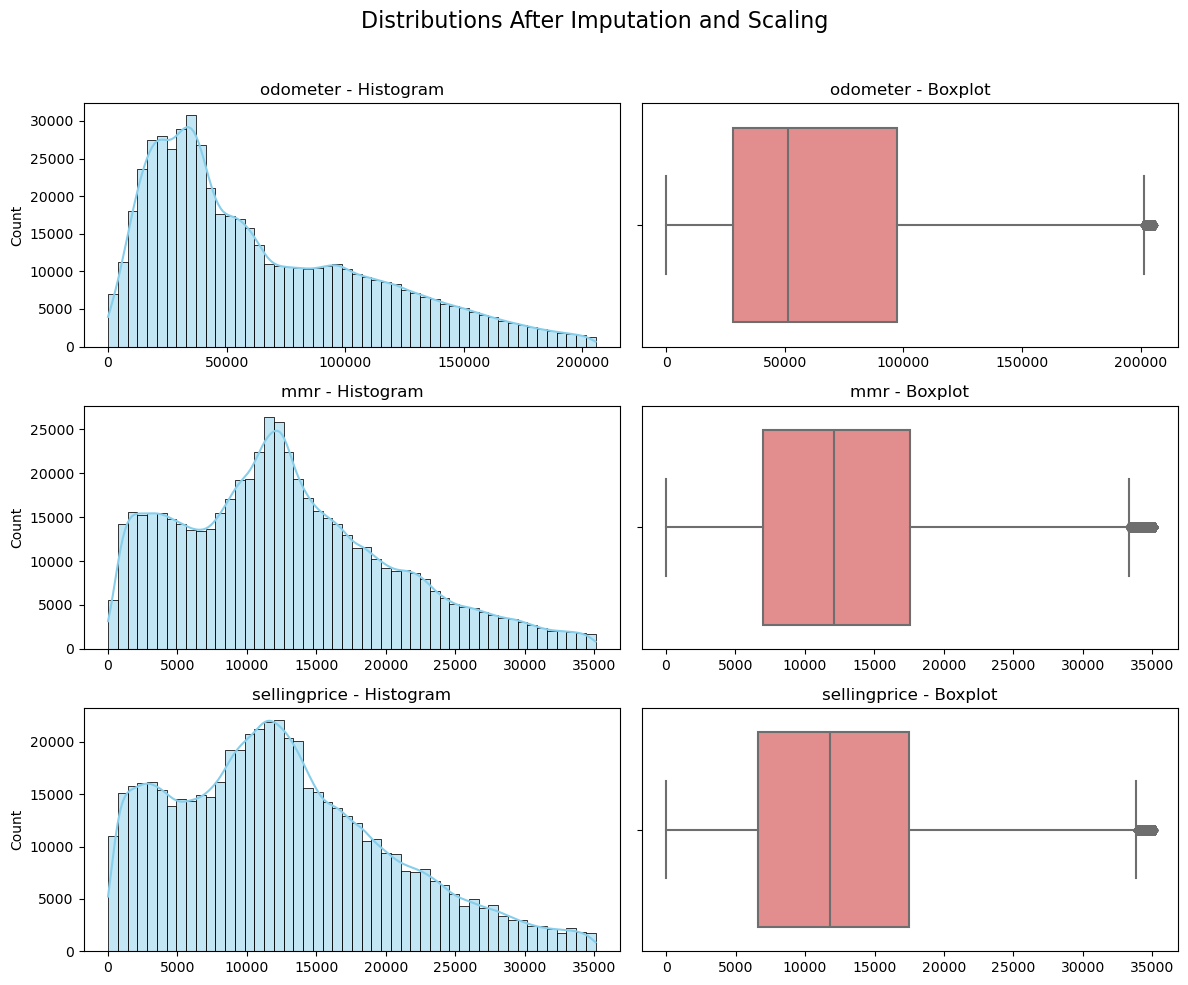

In [15]:
# Choose columns to visualize
cols = ['odometer', 'mmr', 'sellingprice']

# Set up subplots
fig, axes = plt.subplots(len(cols), 2, figsize=(12, 10))
fig.suptitle('Distributions After Imputation and Scaling', fontsize=16)

for i, col in enumerate(cols):
    # Histogram
    sns.histplot(df1[col], bins=50, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'{col} - Histogram')
    axes[i, 0].set_xlabel('')
    
    # Boxplot
    sns.boxplot(x=df1[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'{col} - Boxplot')
    axes[i, 1].set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
df1 = df1.reset_index(drop=True)
df_final = df.copy().reset_index(drop=True)

df_final[['odometer', 'mmr', 'sellingprice']] = df1[['odometer', 'mmr', 'sellingprice']]

In [17]:
df_final.isnull().sum()

year             4001
make            10104
model           10202
trim            10451
body            12987
transmission    64472
vin                 0
state               0
condition           0
odometer            0
color             744
interior          744
seller              0
mmr                 0
sellingprice        0
saledate           12
dtype: int64

In [18]:
df_final['make'] = (df_final['make'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())
df_final['model'] = (df_final['model'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())
df_final['trim'] = (df_final['trim'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())
df_final['body'] = (df_final['body'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())
df_final['transmission'] = (df_final['transmission'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())
df_final['color'] = (df_final['color'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())
df_final['interior'] = (df_final['interior'].astype(str).str.encode('ascii', 'ignore').str.decode('ascii').str.replace(r'\s+', ' ', regex=True).str.strip().str.lower())

In [19]:
df_final['make'] = df_final['make'].replace('nan', np.nan)
df_final['model'] = df_final['model'].replace('nan', np.nan)
df_final['trim'] = df_final['trim'].replace('nan', np.nan)
df_final['body'] = df_final['body'].replace('nan', np.nan)
df_final['transmission'] = df_final['transmission'].replace('nan', np.nan)
df_final['color'] = df_final['color'].replace('nan', np.nan)
df_final['interior'] = df_final['interior'].replace('nan', np.nan)

In [20]:
df_final['make'] = df_final['make'].fillna('unknown')
df_final['model'] = df_final['model'].fillna('unknown')
df_final['trim'] = df_final['trim'].fillna('unknown')
df_final['body'] = df_final['body'].fillna('unknown')
df_final['transmission'] = df_final['transmission'].fillna('unknown')
df_final['color'] = df_final['color'].fillna('unknown')
df_final['interior'] = df_final['interior'].fillna('unknown')

In [21]:
categorical_cols = [
    'make',  
    'model', 
    'trim',
    'body',
    'transmission',
    'color',
    'interior'
]
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df_final[col].unique())


Unique values in 'make':
['kia' 'bmw' 'volvo' 'nissan' 'chevrolet' 'audi' 'ford' 'hyundai' 'buick'
 'cadillac' 'acura' 'lexus' 'infiniti' 'jeep' 'mercedes-benz' 'mitsubishi'
 'mazda' 'mini' 'land rover' 'lincoln' 'jaguar' 'volkswagen' 'toyota'
 'subaru' 'scion' 'porsche' 'unknown' 'dodge' 'fiat' 'chrysler' 'ferrari'
 'honda' 'gmc' 'ram' 'smart' 'bentley' 'pontiac' 'saturn' 'maserati'
 'mercury' 'hummer' 'landrover' 'mercedes' 'gmc truck' 'saab' 'suzuki'
 'oldsmobile' 'isuzu' 'dodge tk' 'geo' 'rolls-royce' 'mazda tk'
 'hyundai tk' 'mercedes-b' 'vw' 'daewoo' 'chev truck' 'ford tk' 'plymouth'
 'ford truck' 'tesla' 'airstream' 'dot' 'aston martin' 'fisker'
 'lamborghini' 'lotus']

Unique values in 'model':
['sorento' '3 series' 's60' '6 series gran coupe' 'altima' 'm5' 'cruze'
 'a4' 'camaro' 'a6' 'optima' 'fusion' 'sonata' 'q5' '6 series' 'impala'
 '5 series' 'a3' 'xc70' 'x5' 'sq5' 's5' 'verano' 'suburban' 'elr' 'v60'
 'x6' 'ilx' 'k900' 'malibu' 'rx 350' 'versa' 'elantra' 'versa note' 'a8

In [22]:
make_map = {
    'chev truck': 'chevrolet',
    'ford tk': 'ford',
    'ford truck': 'ford',
    'ford': 'ford',
    'gmc truck': 'gmc',
    'vw': 'volkswagen',
    'mercedes': 'mercedes-benz',
    'mercedes-b': 'mercedes-benz',
    'landrover': 'land rover',
    'mazda tk': 'mazda',
    'hyundai tk': 'hyundai',
    'dodge tk': 'dodge',
}
df_final['make'] = df_final['make'].replace(make_map)
make_counts = df_final['make'].value_counts()

rare_makes = make_counts[make_counts < 100].index
df_final['make'] = df_final['make'].apply(lambda x: 'other' if x in rare_makes else x)

In [23]:
model_map = {
    # Ford
    'f-150 heritage': 'f-150',
    'f-150 svt lightning': 'f-150',
    'f250': 'f-250',
    'f-250 super duty': 'f-250',
    'f350': 'f-350',
    'f-350 super duty': 'f-350',
    'f-450 super duty': 'f-450',
    'expeditn': 'expedition',
    'expedit': 'expedition',
    'explorer sport trac': 'explorer',
    'taurus x': 'taurus',
    'escape hybrid': 'escape',

    # Chevrolet
    'chev truck': 'silverado',
    'silverado 1500hd': 'silverado',
    'silverado 2500hd classic': 'silverado',
    'silverado 1500 classic': 'silverado',
    'silverado 3500hd': 'silverado',
    'silverado 3500 classic': 'silverado',
    'silverado 2500hd': 'silverado',
    'silverado 1500': 'silverado',
    'silverado 2500': 'silverado',
    'silverado 3500': 'silverado',
    'impala limited': 'impala',
    'malibu classic': 'malibu',
    'camaro convertible': 'camaro',

    # Mazda
    'mazdaspeed3': 'mazda3',
    'mazdaspeed mazda3': 'mazda3',
    'mazdaspeed mx-5 miata': 'mx-5 miata',
    'mazdaspeed protege': 'protege',
    'mazdaspeed mazda6': 'mazda6',

    # Nissan
    'pathfind': 'pathfinder',
    'rogue select': 'rogue',
    'altima hybrid': 'altima',

    # BMW
    '3 series gran turismo': '3 series',
    '5 series gran turismo': '5 series',
    'activehybrid x6': 'x6',
    'activehybrid 7': '7 series',
    'activehybrid 5': '5 series',
    'x5 m': 'x5',
    'x6 m': 'x6',
    '750li': '7 series',
    '750i': '7 series',
    '328i': '3 series',
    '320i': '3 series',
    '323i': '3 series',
    '325i': '3 series',
    '330i': '3 series',
    '335i': '3 series',

    # Infiniti
    'g37 convertible': 'g37',
    'g37 coupe': 'g37',
    'g35': 'g-series',
    'g6': 'g-series',
    'g5': 'g-series',
    'g8': 'g-series',
    'qx56': 'qx',
    'qx60': 'qx',
    'qx70': 'qx',
    'qx80': 'qx',

    # Lexus
    'rx 350': 'rx',
    'rx 450h': 'rx',
    'rx 400h': 'rx',
    'is 250': 'is',
    'is 250 c': 'is',
    'is 350': 'is',
    'is 350 c': 'is',
    'is 300': 'is',
    'es 300': 'es',
    'es 330': 'es',
    'es 350': 'es',
    'es 300h': 'es',
    'gs 300': 'gs',
    'gs 350': 'gs',
    'gs 430': 'gs',
    'gs 450h': 'gs',
    'gs 460': 'gs',
    'ls 430': 'ls',
    'ls 460': 'ls',
    'ls 600h l': 'ls',
    'sc 430': 'sc',
    'sc 400': 'sc',
    'sc 300': 'sc',
    'ct 200h': 'ct',
    'gx 470': 'gx',
    'gx 460': 'gx',
    'lx 470': 'lx',
    'lx 570': 'lx',
    'rc 350': 'rc',
    'rc f': 'rc',

    # Mercedes-Benz
    'glk-class': 'glk',
    'gl-class': 'gl',
    'g-class': 'g',
    'm-class': 'm',
    'slk-class': 'slk',
    'sl-class': 'sl',
    'cls-class': 'cls',
    'clk-class': 'clk',
    'c-class': 'c',
    'e-class': 'e',
    's-class': 's',
    'r-class': 'r',
    'gla-class': 'gla',
    'cla-class': 'cla',

    # Volkswagen
    'jetta sportwagen': 'jetta',
    'jetta gli': 'jetta',
    'golf gti': 'golf',
    'golf r': 'golf',
    'passat cc': 'passat',
    'touareg 2': 'touareg',

    # Dodge
    'ram pickup 1500': 'ram 1500',
    'ram pickup 2500': 'ram 2500',
    'ram pickup 3500': 'ram 3500',
    'ram3500': 'ram 3500',
    'ram van': 'ram',
    'journey': 'journey',
    'charger': 'charger',
    'challenger': 'challenger',
    'dart': 'dart',
    'avenger': 'avenger',

    # Acura
    'tsx sport wagon': 'tsx',
    'rlx': 'rlx',
    'tlx': 'tlx',
    'zdx': 'zdx',

    # Tesla
    'model s': 'model s',
    'model x': 'model x',
    'model 3': 'model 3',
    'model y': 'model y',

    # Miscellaneous corrections
    'subrbn': 'suburban',
    'siera': 'sierra',
    'expeditn': 'expedition',
    'expedit': 'expedition',
    'pathfind': 'pathfinder',
    'mazdaspeed3': 'mazda3',
    'mazdaspeed mazda3': 'mazda3',
    'mazdaspeed mx-5 miata': 'mx-5 miata',
    'mazdaspeed protege': 'protege',
    'mazdaspeed mazda6': 'mazda6',
}
df_final['model'] = df_final['model'].replace(model_map)

model_counts = df_final['model'].value_counts()
rare_models = model_counts[model_counts < 50].index
df_final['model'] = df_final['model'].apply(lambda x: 'other' if x in rare_models else x)

In [24]:
df_final['transmission'] = df_final['transmission'].replace({'sedan': 'unknown'})

In [25]:
color_map = {
    'off-white': 'white',
    'charcoal': 'gray',
    'lime': 'green',
    'burgundy': 'red',
    'beige': 'brown',
    'silver': 'gray',
    'gold': 'yellow',
    'pink': 'red',
    'turquoise': 'blue',
    '4802': 'unknown',
    '': 'unknown'
}
df_final['color'] = df_final['color'].replace(color_map)

In [26]:
interior_map = {
    'off-white': 'white',
    'tan': 'beige',
    'silver': 'gray',
    'gold': 'yellow',
    'burgundy': 'red',
    '': 'unknown'
}
df_final['interior'] = df_final['interior'].replace(interior_map)

In [27]:
trim_map = {
    # Base and entry-level
    'base': 'base',
    'standard': 'base',
    'value leader': 'base',
    'fleet': 'base',
    'ls': 'base',
    'ce': 'base',
    'dx': 'base',
    'gl': 'base',
    'classic': 'base',

    # Mid-tier trims
    'le': 'mid',
    'se': 'mid',
    'xle': 'mid',
    'lt': 'mid',
    'lt1': 'mid',
    'lt2': 'mid',
    'lt3': 'mid',
    'gls': 'mid',
    's': 'mid',
    'sv': 'mid',
    'sx': 'mid',
    'ex': 'mid',
    'ex-l': 'mid',
    'ex v-6': 'mid',
    'ex-l v-6': 'mid',
    'lx': 'mid',
    'lx-p': 'mid',
    'lx-s': 'mid',
    'lx hybrid': 'mid',
    'lx-v6': 'mid',
    'xls': 'mid',
    'xlt': 'mid',
    'xlt sport': 'mid',
    'xlt choice': 'mid',
    'xlt popular': 'mid',
    'sle': 'mid',
    'sle-1': 'mid',
    'sle-2': 'mid',
    'slt': 'mid',
    'slt-1': 'mid',
    'slt-2': 'mid',
    'slt plus': 'mid',
    'cxl': 'mid',
    'cxl1': 'mid',
    'cxl2': 'mid',

    # Premium and luxury
    'limited': 'luxury',
    'platinum': 'luxury',
    'platinum edition': 'luxury',
    'signature': 'luxury',
    'signature limited': 'luxury',
    'luxury': 'luxury',
    'luxury iii': 'luxury',
    'premium': 'luxury',
    'premium i': 'luxury',
    'premium ii group': 'luxury',
    'premium group': 'luxury',
    'premium i group': 'luxury',
    'touring': 'luxury',
    'touring-l': 'luxury',
    'grand touring': 'luxury',
    'limited edition': 'luxury',
    'limited 7-passenger': 'luxury',
    'limited pzev': 'luxury',
    'limited ffv': 'luxury',
    'advance package': 'luxury',
    'technology package': 'luxury',
    'comfort': 'luxury',
    'executive': 'luxury',
    'prestige quattro': 'luxury',

    # Performance trims
    'gt': 'performance',
    'gt premium': 'performance',
    'gt deluxe': 'performance',
    'gt1': 'performance',
    'gt2': 'performance',
    'gts': 'performance',
    'gxp': 'performance',
    'g37 sport': 'performance',
    'g37x': 'performance',
    'g25x': 'performance',
    'g37 journey': 'performance',
    'g35': 'performance',
    'g25': 'performance',
    'gxe': 'performance',
    'type-s': 'performance',
    'srt8': 'performance',
    'srt-8': 'performance',
    'ss': 'performance',
    'rs': 'performance',
    'rs 4': 'performance',
    'rs 5': 'performance',
    'rs 6': 'performance',
    'rs 7': 'performance',
    'svt raptor': 'performance',
    'sho': 'performance',
    'wrx': 'performance',
    'wrx sti': 'performance',
    'sti': 'performance',
    'nismo': 'performance',
    'z06': 'performance',
    'z51': 'performance',
    'z71': 'performance',
    'z85': 'performance',
    'cla250': 'performance',
    'c63 amg': 'performance',
    'e63 amg': 'performance',
    'slk350': 'performance',
    'slk250': 'performance',
    's550': 'performance',
    's550 4matic': 'performance',
    's500': 'performance',
    's430': 'performance',
    'clk350': 'performance',
    'clk500': 'performance',
    'clk320': 'performance',
    'cls550': 'performance',
    'cls550 4matic': 'performance',
    'cls500': 'performance',
    'ml500': 'performance',
    'e500': 'performance',
    'e550': 'performance',
    'e350 sport': 'performance',
    'e350 sport bluetec': 'performance',
    'e350 sport 4matic': 'performance',
    'c350 sport': 'performance',
    'c300 sport': 'performance',
    'c300 sport 4matic': 'performance',
    'c300 luxury': 'performance',
    'c300 luxury 4matic': 'performance',
    'c230 sport': 'performance',
    'c230 kompressor': 'performance',
    'c230': 'performance',
    'c240': 'performance',
    'c320': 'performance',
    'c280 luxury 4matic': 'performance',
    'cla-class': 'performance',
    'gla-class': 'performance',
    'glk350': 'performance',
    'glk350 4matic': 'performance',
    'gl550': 'performance',
    'gl550 4matic': 'performance',
    'gl450': 'performance',
    'gl450 4matic': 'performance',
    'gl350 bluetec': 'performance',
    'ml350': 'performance',
    'ml350 4matic': 'performance',
    'ml350 bluetec': 'performance',
    'r350': 'performance',
    'r350 4matic': 'performance',

    # Drivetrain and engine indicators
    'awd': 'drivetrain',
    'fwd': 'drivetrain',
    'rwd': 'drivetrain',
    'quattro': 'drivetrain',
    'xdrive': 'drivetrain',
    'sdrive': 'drivetrain',
    '4matic': 'drivetrain',
    '4motion': 'drivetrain',
    'pzev': 'drivetrain',
    'hybrid': 'drivetrain',
    'bluetech': 'drivetrain',
    'eco': 'drivetrain',
    'turbo': 'drivetrain',
    'supercharged': 'drivetrain',
    'v6': 'drivetrain',
    'v8': 'drivetrain',
    'v8 se': 'drivetrain',
    'v6 touring': 'drivetrain',
    'fwd v6 touring': 'drivetrain',

    # Miscellaneous
    'other': 'other',
    'special edition': 'other',
    'wolfsburg edition': 'other',
    'american value package': 'other',
    'value package': 'other',
    'convenience group': 'other',
    'comfort package': 'other',
    'technology package': 'other',
    'advance package': 'other',
    'deluxe': 'other',
    'mainstreet': 'other',
    'express': 'other',
    'crew': 'other',
    'work truck': 'other',
    'cargo van': 'other',
    'tradesman': 'other',
    'king ranch': 'other',
    'laramie': 'other',
    'laramie longhorn edition': 'other',
    'rubicon': 'other',
    'sahara': 'other',
    'unlimited': 'other',
    'unlimited rubicon': 'other',
    'unlimited sahara': 'other',
    'unlimited sport': 'other',
    'unlimited x': 'other',
}
df_final['trim'] = df_final['trim'].replace(interior_map)

trim_counts = df_final['trim'].value_counts()
rare_trims = trim_counts[trim_counts < 50].index
df_final['trim'] = df_final['trim'].apply(lambda x: 'other' if x in rare_trims else x)

In [28]:
# Convert saledate to datetime format
df_final['saledate'] = pd.to_datetime(df_final['saledate'], errors='coerce', utc=True)

# Confirm dtype
print(df_final['saledate'].dtype)

/tmp/ipykernel_1801/2889138664.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final['saledate'] = pd.to_datetime(df_final['saledate'], errors='coerce', utc=True)


datetime64[ns, UTC]


In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550297 entries, 0 to 550296
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          546296 non-null  float64            
 1   make          550297 non-null  object             
 2   model         550297 non-null  object             
 3   trim          550297 non-null  object             
 4   body          550297 non-null  object             
 5   transmission  550297 non-null  object             
 6   vin           550297 non-null  object             
 7   state         550297 non-null  object             
 8   condition     550297 non-null  float64            
 9   odometer      550297 non-null  float64            
 10  color         550297 non-null  object             
 11  interior      550297 non-null  object             
 12  seller        550297 non-null  object             
 13  mmr           550297 non-null  float64      

In [30]:
df_final = df_final.dropna(subset='year')

In [31]:
df_final.to_feather('cleaned_vehicle_data.feather')

In [32]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546296 entries, 0 to 550296
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          546296 non-null  float64            
 1   make          546296 non-null  object             
 2   model         546296 non-null  object             
 3   trim          546296 non-null  object             
 4   body          546296 non-null  object             
 5   transmission  546296 non-null  object             
 6   vin           546296 non-null  object             
 7   state         546296 non-null  object             
 8   condition     546296 non-null  float64            
 9   odometer      546296 non-null  float64            
 10  color         546296 non-null  object             
 11  interior      546296 non-null  object             
 12  seller        546296 non-null  object             
 13  mmr           546296 non-null  float64           

In [33]:
# Check how many rows have the string 'nan'
print((df_final['interior'] == 'nan').sum())

0
